#### Dependencias

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import DMatrix, train, cv, plot_importance
import seaborn

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

#### Variables

In [3]:
DATAPATH = Path(os.getcwd()).parent / 'data'
SEED = 1399

#### Leer datos

In [4]:
df = pd.read_csv(DATAPATH / 'train.csv').drop('Id', axis=1)
print(f'Filas: {df.shape[0]:,}')
print(f'Columnas: {df.shape[1]:,}')
df.head(5)

Filas: 1,460
Columnas: 80


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Modelo baseline

In [5]:
X, y = df.drop(['SalePrice'], axis=1), df['SalePrice']

In [6]:
object_mask = X.select_dtypes('object').columns
X[object_mask] = X[object_mask].astype('category')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
print(f'Train: {X_train.shape}')
print(f'Train: {X_test.shape}')

Train: (1168, 79)
Train: (292, 79)


In [8]:
dtrain = DMatrix(data=X_train, label=y_train, feature_names=X.columns.tolist(), enable_categorical=True)
dtest = DMatrix(data=X_test, label=y_test, feature_names=X.columns.tolist(), enable_categorical=True)

In [9]:
params = {
    'eta': 0.01,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': ['rmse', 'mae'],
    'nthread': 24,
    'seed': SEED,
    'verbosity': 1
}

In [10]:
cv_results = cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=10,
    verbose_eval=10,
    show_stdv=False
)

[0]	train-rmse:78412.29145	train-mae:56573.96348	test-rmse:78272.32735	test-mae:56626.00933
[10]	train-rmse:72082.99547	train-mae:51814.26895	test-rmse:72668.53768	test-mae:52210.00539
[20]	train-rmse:66352.69626	train-mae:47522.10117	test-rmse:67714.40263	test-mae:48338.16267
[30]	train-rmse:61137.96170	train-mae:43617.16809	test-rmse:63186.16299	test-mae:44818.40949
[40]	train-rmse:56387.79877	train-mae:40075.61186	test-rmse:59294.28005	test-mae:41705.24110
[50]	train-rmse:52050.71697	train-mae:36845.98343	test-rmse:55831.03180	test-mae:38883.05323
[60]	train-rmse:48101.54368	train-mae:33913.61922	test-rmse:52801.58133	test-mae:36364.87473
[70]	train-rmse:44501.40266	train-mae:31254.47227	test-rmse:50153.41776	test-mae:34109.01957
[80]	train-rmse:41219.98507	train-mae:28844.79172	test-rmse:47835.77763	test-mae:32095.84273
[90]	train-rmse:38232.95915	train-mae:26659.32067	test-rmse:45790.91697	test-mae:30335.53812
[100]	train-rmse:35489.72494	train-mae:24667.95022	test-rmse:43911.4334

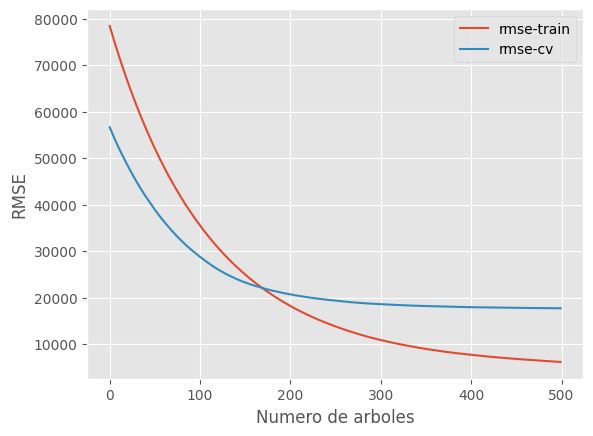

In [11]:
plt.plot(cv_results[['train-rmse-mean', 'test-mae-mean']], label=['rmse-train', 'rmse-cv'])
plt.legend()
plt.xlabel('Numero de arboles')
plt.ylabel('RMSE')
plt.show()

In [12]:
model = train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain,'train'), (dtest,'eval')],
    early_stopping_rounds=10,
    num_boost_round=500,
    verbose_eval=10
)

[0]	train-rmse:78431.64870	train-mae:56565.98666	eval-rmse:79992.57700	eval-mae:58662.59974
[10]	train-rmse:72063.55126	train-mae:51774.11312	eval-rmse:73986.60333	eval-mae:53864.48710
[20]	train-rmse:66305.46054	train-mae:47474.68652	eval-rmse:68639.30821	eval-mae:49544.88463
[30]	train-rmse:61076.36147	train-mae:43601.08322	eval-rmse:63824.43333	eval-mae:45690.28077
[40]	train-rmse:56328.67860	train-mae:40058.92711	eval-rmse:59528.54591	eval-mae:42261.81068
[50]	train-rmse:51988.94012	train-mae:36856.27274	eval-rmse:55786.52099	eval-mae:39154.73223
[60]	train-rmse:48036.24435	train-mae:33930.22510	eval-rmse:52278.67026	eval-mae:36322.11403
[70]	train-rmse:44438.10407	train-mae:31307.76979	eval-rmse:49187.54575	eval-mae:33874.31667
[80]	train-rmse:41167.20061	train-mae:28921.24413	eval-rmse:46509.50013	eval-mae:31764.63803
[90]	train-rmse:38187.79353	train-mae:26748.06152	eval-rmse:44148.45998	eval-mae:29914.06796
[100]	train-rmse:35480.00654	train-mae:24784.30870	eval-rmse:41938.6793

In [13]:
predictions = model.predict(dtest)
print(f'RMSE: {mean_squared_error(dtest.get_label(), predictions, squared=False):} USD')

RMSE: 25230.244140625 USD


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

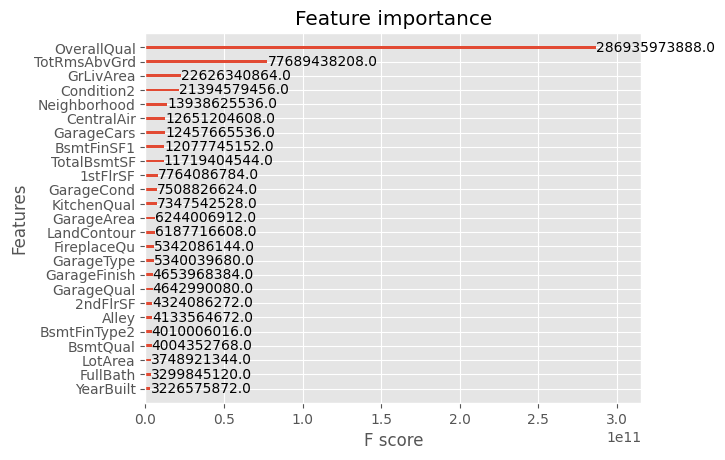

In [14]:
plot_importance(model, importance_type='gain', max_num_features=25)